In [ ]:
import pandas as pd
import os
import re
import pydicom as dicom
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import cv2
import scipy
from ipywidgets import interact, IntSlider, VBox, Layout, interactive_output
from IPython.display import display
import time
from scipy import ndimage
import math
import psutil
import cupy as cp 
import cupyx.scipy.ndimage
import sys

In [3]:
!jupyter nbextension enable --sys-prefix --py widgetsnbextension

Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
basedir = 'file_path'
paths = pd.read_csv(basedir + "datafile.csv")

def get_patient_dir(pid, year, paths_df):
    '''
    Return: path to patient directory
    Parameters:
        pid: patient ID (int)
        year: patient year (string)
        paths_df: DataFrame with paths to each patient directory
    '''
    patient_year = paths_df[(paths_df["pid"] == pid) & (paths_df["year"] == year)]
    path = patient_year["best image folder address"].iloc[0]
    return path
    
p_t2_path = get_patient_dir(pid, time, paths)

In [ ]:
def get_image_paths(dir_path):
    '''
    Return: DataFrame with file path for each image for a specific patient, time point, and kernel
    Parameters:
        dir_path: path to patient directory
    '''
    dcm_files = pd.DataFrame(columns=['Patient ID', 'File', 'Full path', 'Time point', 'Kernel','Slice location'])
    for root, dirs, files in os.walk(p_t2_path, topdown=False):
        for name in files:
            if '.dcm' in name:
                full_path = os.path.join(root, name)

                pattern = '\/(\d+)\/'
                patient_id = re.findall(pattern, full_path)[0]

                annotation = dicom.read_file(full_path)
                time_point = annotation.ClinicalTrialTimePointID
                kernel = annotation.ConvolutionKernel
                slice_location = annotation.SliceLocation


                new_df = pd.DataFrame({"File": [name], "Patient ID": [patient_id], "Full path": [full_path], 
                                       "Time point": [time_point], 'Kernel': [kernel],'Slice location': [slice_location]})

                dcm_files = pd.concat([dcm_files, new_df])
                
    return dcm_files

In [ ]:
p_dcm_files = get_image_paths(p_t2_path)

In [ ]:
imgs_to_process = cp.array(imgs).astype(cp.float64) 
imgs_as_numpy = cp.asnumpy(imgs_to_process)

In [19]:
#Source: https://www.kaggle.com/code/gzuidhof/full-preprocessing-tutorial

def load_scan(file_paths):
    '''
    Return: list of DICOM files 
    Parameters: 
        file_paths: list of paths to all the DICOM images
        
    Create a list of DICOM files and change SliceThickness. 
    '''
    
    slices = []
    for file in file_paths:
        slices.append(dicom.read_file(file))
        
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices


def get_pixels_hu(scans):
    '''
    Return: array of DICOM image pixel arrays
    Parameters: 
        scans: array of DICOM files
        
    Convert raw voxel values of the DICOM images into Houndsfeld units. 
    '''
    
    image = np.stack([s.pixel_array for s in scans])
    
    # Convert to int16 (from sometimes int16)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


def resample(images, scan):
    '''
    Return:
        resampled_images: array of DICOM image pixel arrays
        new_spacing: array, new pixel spacing
    Parameters: 
        images: array of DICOM images
        scan: array of DICOM images
        
    Resample each slice in 1mm x 1mm x 1mm pixels and slices. 
    '''
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / [1,1,1]
    new_real_shape = images.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / images.shape
    new_spacing = spacing / real_resize_factor
    
    resampled_images = scipy.ndimage.interpolation.zoom(images, real_resize_factor, mode='nearest')
    
    return resampled_images, new_spacing

In [20]:
def process_images(paths_df):
    '''
    Return:
        resampled_images: cupy array of DICOM image pixel arrays
    Parameters: 
        paths_df: DataFrame with list of paths to all the DICOM images
        
    Sort and resample images.
    '''
    sorted_df = paths_df.sort_values("Slice location", ascending = False)   
    patients = load_scan(sorted_df["Full path"])
    imgs = get_pixels_hu(patients)
    imgs_after_resamp, spacing = resample(imgs, patients)
    return cp.array(imgs_after_resamp)
    

imgs_after_process_cp = process_images(p_dcm_files)

/tmp/ipykernel_1093570/799505413.py:80: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  resampled_images = scipy.ndimage.interpolation.zoom(images, real_resize_factor, mode='nearest')


In [21]:
def show_plane(ax, image, rescale=True, cmap="gray", title=None):
    '''
    Return: N/A
    Parameters:
        ax:figure subplot
        image: image array
        rescale: whether to rescale the image or not (boolean)
        cmap: colormap (str)
        title: plot title
    Plot image
    '''
    
    if rescale:
        ax.imshow(image, cmap=cmap, aspect = image.shape[1]/image.shape[0])
    else:
        ax.imshow(image, cmap=cmap)    

    if title:
        ax.set_title(title)

    return None

In [22]:
def rotate_coronal(data, angle, slice_num):
    '''
    Return: cupy array of rotated image
    Parameters:
        data: image array
        angle: angle from coronal to rotate
        slice_num: image plane, distance from 0 (center)
    '''
    if angle != 0:
        array_angle = cupyx.scipy.ndimage.rotate(data, angle, axes=(2,1))
    else: 
        array_angle = data
    
    sz, sy, sx = array_angle.shape
    slice_loc = sy//2 + slice_num
    return cp.asnumpy(array_angle[:, slice_loc, :])


def rotate_axial(data, angle, slice_num):
    '''
    Return: cupy array of rotated image
    Parameters:
        data: image array
        angle: angle from axial to rotate
        slice_num: image plane, distance from 0 (center)
    '''
    array_angle1 = cupyx.scipy.ndimage.rotate(data, -90, axes=(1, 0))
    
    if angle != 0:
        array_angle2 = cupyx.scipy.ndimage.rotate(array_angle1, angle, axes=(2, 1))
    else:
        array_angle2 = array_angle1
    
    sz, sy, sx = array_angle2.shape
    slice_loc = sy//2 + slice_num
    return cp.asnumpy(array_angle2[:, slice_loc, :])

In [23]:
def get_angle_proj_xy(ref_pt, pt2):
    '''
    Return: x and y angles (in degrees)
    Parameters: 
        ref_pt: starting point
        pt2: end point
    Project vector onto xy-plane and calculate angles.
    '''
    d = np.subtract(pt2, ref_pt)
    d_proj = (d[0], d[1], 0)
    mag = np.sqrt(d.dot(d_proj))
    
    x_ax = (1, 0, 0)
    y_ax = (0, 1, 0)
    
    x_dot = pt2[0] - ref_pt[0]
    y_dot = pt2[1] - ref_pt[1]
    
    x_angle = math.degrees(np.arccos(x_dot / mag))
    y_angle = math.degrees(np.arccos(y_dot / mag))
    
    return x_angle, y_angle


def get_angle_proj_xz(ref_pt, pt2):
    '''
    Return: x and y angles (in degrees)
    Parameters: 
        ref_pt: starting point
        pt2: end point
    Project vector onto xz-plane and calculate angles.
    ''' 
    d = np.subtract(pt2, ref_pt)
    d_proj = (d[0], 0, d[2])
    mag = np.sqrt(d.dot(d_proj))
    
    x_ax = (1, 0, 0)
    z_ax = (0, 0, 1)
    
    z_dot = pt2[2] - ref_pt[2] 
    x_dot = pt2[0] - ref_pt[0] 
    
    z_angle = math.degrees(np.arccos(z_dot / mag))
    x_angle = math.degrees(np.arccos(x_dot / mag))
    
    return x_angle, z_angle

In [24]:
#Source: https://stackoverflow.com/questions/938733/total-memory-used-by-python-process

def get_process_memory():
    '''
    Return: memory usage of process (in bytes)
    '''
    process = psutil.Process(os.getpid())
    return process.memory_info().rss 


def track(func):
    '''
    Return: runtime and memory usage
    Parameters:
        func: function to track
    Track runtime and memory usage of a function
    '''
    def wrapper(*args, **kwargs):
        mem_before = get_process_memory()
        start_time = time.time()
        result = func(*args, **kwargs)
        elapsed_time = time.time() - start_time
        mem_after = get_process_memory() 
        mem_consumed = (mem_after - mem_before) 
        print("{}: memory consumed: {:,}; exec time: {} seconds".format(
            func.__name__,
            mem_consumed,
            elapsed_time))
        return result
    return wrapper

In [24]:
@track
def mpr_angles(data, cmap='gray', rescale=True, x=0, z=0, xy_angle=0, xz_angle=0):
    '''
    Return: N/A
    Parameters:
        data: image array
        cmap: colormap (str)
        rescale: whether to rescale the image or not (boolean)
        x: distance to translate in x-axis
        z: distance to translate in z-axis
        xy_angle: angle to rotate from coronal
        yz_angle: angle to rotate from axial
    
    Display 3 planes, rotate from each axis using the inputted angles. 
    '''   
    def display_slice(plane):
        
        fig = plt.figure(figsize=(15,15))
        co = fig.add_subplot(221)
        sa = fig.add_subplot(222)
        ax = fig.add_subplot(223)
        plot_arr = [co, sa, ax]
        
        c_slice = rotate_coronal(data, xy_angle, plane)
        a_slice = rotate_axial(data, xz_angle, z)
        s_slice = rotate_coronal(data, 90+xy_angle, x)
        slice_arr = [c_slice, s_slice, a_slice]
        name = ["Rotation from coronal", "Rotation from sagittal", "Rotation from axial"]


        for i in range(3):
            show_plane(plot_arr[i], slice_arr[i], title='{} plane'.format(name[i]), cmap=cmap, 
                       rescale = rescale)

    
    midpoint = data.shape[0] // 2
    plane = IntSlider(min=-midpoint, max=midpoint, step=1, 
                                      value=0, 
                      description = 'plane',
                      style = {'description_width': 'initial'},
                     layout = Layout(width = '50%'))

    
    
    ui = VBox([plane])
    out = interactive_output(display_slice, {'plane':plane})
    display(ui, out)

In [ ]:
mpr_angles(imgs_after_process_cp, cmap="gray", x=0, z=0, xy_angle=0, xz_angle=0)

In [ ]:
mpr_angles(imgs_after_process_cp, cmap="gray", x=0, z=0, xy_angle=45, xz_angle=45)

In [25]:
@track
def mpr_line(data, cmap='gray', rescale=True, refPoint=(0, 0, 0), point=(0, 0, 0)):
    '''
    Return: N/A
    Parameters:
        data: image array
        cmap: colormap (str)
        rescale: whether to rescale the image or not (boolean)
        refPoint: starting point, (x, y, z)
        point: end point, (x, ,y, z)
    
    Display 3 planes, rotate from each axis using the inputted points
    '''   
    def display_slice():
        
        fig = plt.figure(figsize=(15,15))
        co = fig.add_subplot(221)
        sa = fig.add_subplot(222)
        ax = fig.add_subplot(223)
        
        plot_arr = [co, sa, ax]
        
        x_angle, y_angle = get_angle_proj_xy(refPoint, point)
        x2_angle, z_angle = get_angle_proj_xz(refPoint, point)
        
        c_slice = rotate_coronal(data, x_angle, refPoint[1]) #in-plane slice
        a_slice = rotate_axial(data, x2_angle, refPoint[2]) #in-plane slice
        s_slice = rotate_coronal(data, 90+x_angle, refPoint[0]) #perpendicular to c_slice
        slice_arr = [c_slice, s_slice, a_slice]
        name = ["Rotation from coronal", "Rotation from sagittal", "Rotation from axial"]
        


        for i in range(len(name)):
            show_plane(plot_arr[i], slice_arr[i], title='{} plane'.format(name[i]), cmap=cmap, 
                       rescale=rescale)


    display_slice()

mpr_line: memory consumed: 0; exec time: 0.35185933113098145 seconds


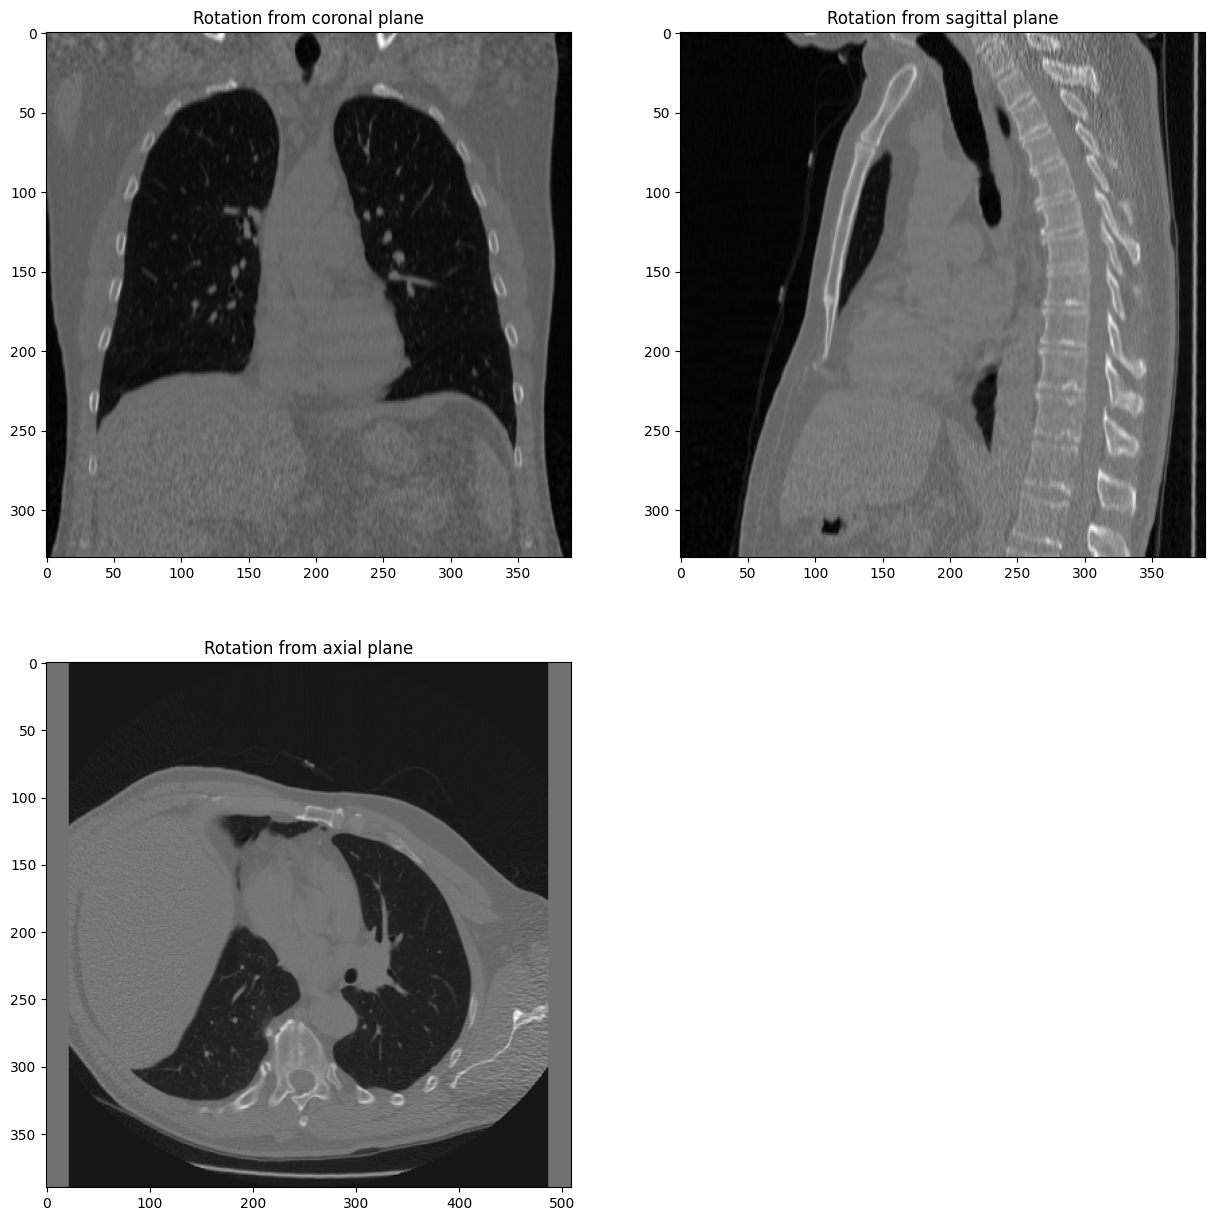

In [28]:
#45 degree angle turn from axial slice
mpr_line(imgs_after_process_cp, cmap='gray', refPoint=(0, 0, 0), point=(100, 0, 100))

mpr_line: memory consumed: 0; exec time: 0.3686950206756592 seconds


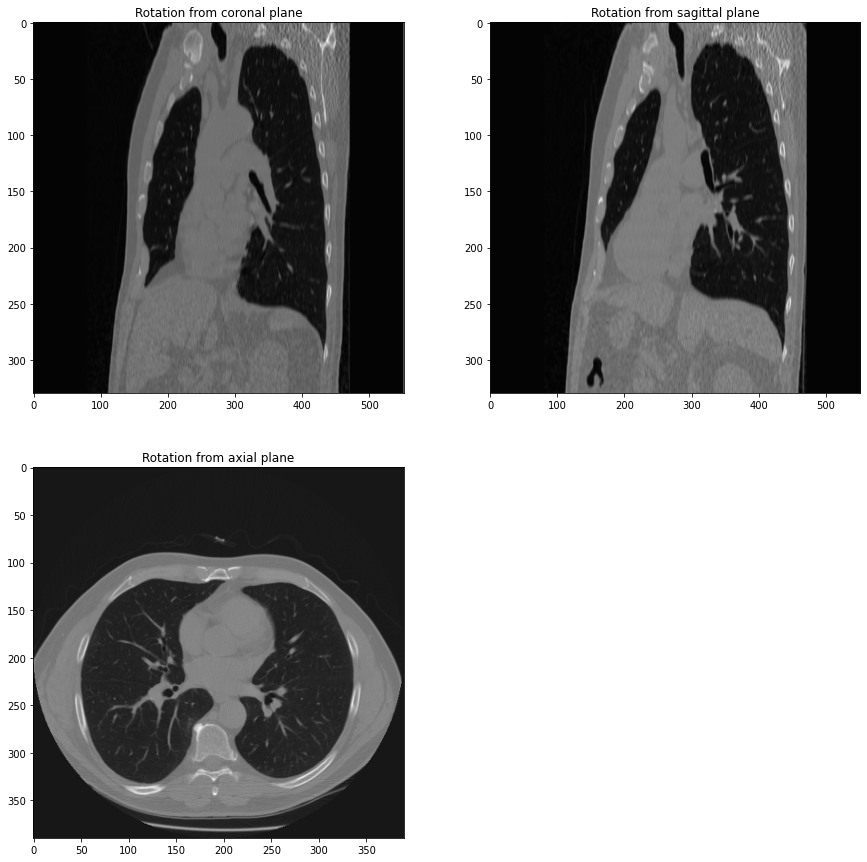

In [42]:
#45 degree turn from coronal slice 
mpr_line(imgs_after_process_cp, cmap='gray', refPoint=(0, 0, 0), point=(100, 100, 0))

mpr_line: memory consumed: 0; exec time: 1.1034650802612305 seconds


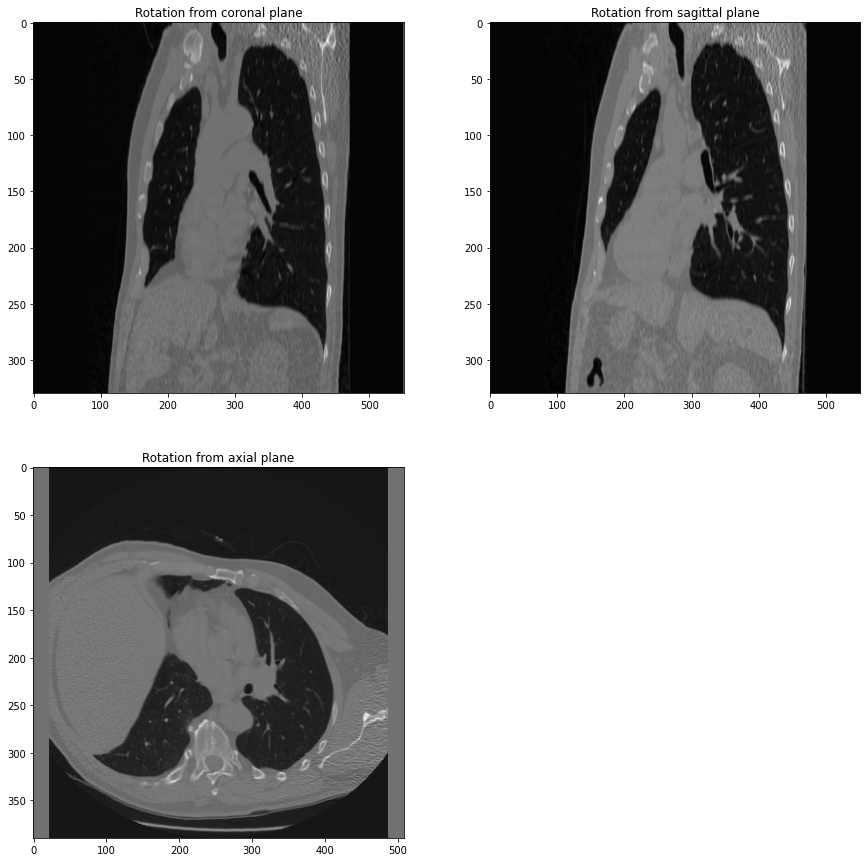

In [45]:
#45 degree turn from coronal and axial slice

mpr_line(imgs_after_process_cp, cmap='gray', refPoint=(0, 0, 0), point=(100, 100, 100))